## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
# 이미지가 28 * 28 픽셀이기 때문에, 784개의 특성을 갖고 있음
print(y.shape)

(70000, 784)
(70000,)


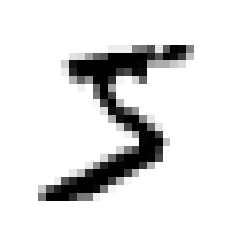

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

some_digit = X.loc[0]
some_digit_image = np.array(some_digit).reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
# 레이블은 문자열이기 때문에, 정수로 변환
print(y[0])
y = y.astype(np.uint8)

5


In [5]:
# MNIST 데이터셋은 이미 훈련 세트와 테스트 세트로 나뉘어져 있음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Binary Classifier Training

In [6]:
# 분류를 위한 타깃 벡터 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=2022)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=2022)

In [8]:
sgd_clf.predict([some_digit])

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

## 3.3 Measure Performance

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2022, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9481
0.949
0.9511


In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96525, 0.94745, 0.9576 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    # 예측 시, 무조건 5 아님으로 예측 (False로 예측)
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53579,  1000],
       [ 1594,  3827]], dtype=int64)

In [15]:
y_train_prefect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [16]:
# precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7928319867412471

In [17]:
recall_score(y_train_5, y_train_pred)

0.705958310274857

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7468774395003902

In [23]:
# Trade-off of precision / recall
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-15068.16963826, -29651.60358376, -11847.23169549,
         -3374.65732295, -19516.78280274,   2672.70747991,
        -20334.05018793, -21949.32945898, -13106.00462301,
        -12815.14997077]])

In [22]:
thresohld = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([[False, False, False, False, False,  True, False, False, False,
        False]])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  5123.10591183, -29796.08959255, -40769.42804345, ...,
         4835.20014047,  -7413.32455359, -11525.86105574])

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family
plt.rc('axes', unicode_minus=False)

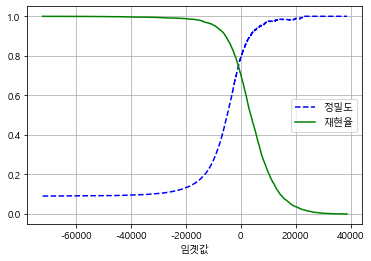

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label='재현율')
    plt.legend()
    plt.xlabel('임곗값')
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()   

In [ ]:
threshold_90_precision = thresholds[np.argmax(preicisions >= 0.90)]

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))